# Progetto social
## Realizzazione di grafi riguardanti le pubblicazioni degli articoli del dipartimento scientifico
Ricerca tramite piattaforma Scopus di pubblicazioni di articoli scientifici dell'università di udine e analisi dei dati.
### Analisi del dataset
Caricamento dataset e valutazione attendibilità dei paramtri


In [30]:
# Lista delle librerie da controllare
import importlib
import subprocess
import sys

# Dizionario: nome_pip -> nome_import
required_packages = {
    "pandas": "pandas",
    "networkx": "networkx",
    "pyvis": "pyvis",
    "matplotlib": "matplotlib",
    "numpy": "numpy",
    "plotly": "plotly",
    "ipython": "IPython",
    "scipy": "scipy"
}

for pip_name, import_name in required_packages.items():
    try:
        importlib.import_module(import_name)
        print(f"{pip_name} già installato ✅")
    except ImportError:
        print(f"{pip_name} non trovato. Installazione in corso...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_name]
        )
        print(f"{pip_name} installato correttamente ✅")

pandas già installato ✅
networkx già installato ✅
pyvis già installato ✅
matplotlib già installato ✅
numpy già installato ✅
plotly già installato ✅
ipython già installato ✅
scipy già installato ✅


In [31]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from IPython.display import display
import itertools
import plotly.graph_objects as go
import scipy

In [32]:
#caricamento dataset grezzo
df=pd.read_csv('dataset.csv')
df.head()

Authors  \
0                           Lancia, G.; Dalpasso, M.   
1  Da Ros, F.; Di Gaspero, L.; Kletzander, L.; La...   
2  Bacchetti, E.; de Nardin, A.; Giannarini, G.; ...   
3  Ozkilinc, O.; Soler, M.A.; Giannozzi, P.; Apar...   
4              Faletič, S.; Micheli, M.; Pospiec, G.   

                                   Author full names  \
0  Lancia, Giuseppe G. (6701584197); Dalpasso, Ma...   
1  Da Ros, Francesca (58134137500); Di Gaspero, L...   
2  Bacchetti, Emiliano (59995162800); de Nardin, ...   
3  Ozkilinc, Ozge (58138235700); Soler, Miguel A....   
4  Faletič, Sergej (56595108900); Micheli, Marisa...   

                                        Author(s) ID  \
0                             6701584197; 6603897248   
1  58134137500; 6505944235; 57194560339; 57188717...   
2  59995162800; 57259162600; 55883317500; 2448058...   
3  58138235700; 8718855800; 7004488307; 572046647...   
4              56595108900; 59664609000; 59665606800   

                                               Title  Year  \
0  Speeding Up Floyd–Warshall’s Algorithm to Comp...  2025   
1  Dynamic Temperature Control of Simulated Annea...  2025   
2  A Deep Learning Model Integrating Clinical and...  2025   
3  The Single-Parameter Bragg–Williams Model for ...  2025   
4  Teaching and learning quantum entanglement: a ...  2025   

                                  Source title Volume Issue Art. No.  \
0                                   Algorithms     18     9      560   
1                                          NaN    NaN   NaN      NaN   
2                                      Cancers     17    13     2257   
3  International Journal of Molecular Sciences     26     3      997   
4        Journal of Physics: Conference Series   2950     1   012025   

  Page start  ...                          ISBN  CODEN   PubMed ID  \
0        NaN  ...                           NaN    NaN         NaN   
1        184  ...                 9798400714658    NaN         NaN   
2        NaN  ...                           NaN    NaN         NaN   
3        NaN  ...                           NaN    NaN  39940766.0   
4        NaN  ...  9788394593742; 9781628905861    NaN         NaN   

  Language of Original Document                   Abbreviated Source Title  \
0                       English                                 Algorithms   
1                       English  GECCO - Proc. Genetic Evol. Comput. Conf.   
2                       English                                    Cancers   
3                       English                          Int. J. Mol. Sci.   
4                       English                        J. Phys. Conf. Ser.   

      Document Type Publication Stage  \
0           Article             Final   
1  Conference paper             Final   
2           Article             Final   
3           Article             Final   
4  Conference paper             Final   

                                         Open Access  Source  \
0                  All Open Access; Gold Open Access  Scopus   
1                                                NaN  Scopus   
2  All Open Access; Gold Open Access; Green Accep...  Scopus   
3  All Open Access; Gold Open Access; Green Accep...  Scopus   
4                  All Open Access; Gold Open Access  Scopus   

                   EID  
0  2-s2.0-105017372448  
1  2-s2.0-105013077196  
2  2-s2.0-105010643815  
3   2-s2.0-85217742685  
4   2-s2.0-85219573912  

[5 rows x 46 columns]

In [33]:
#Test e analisi per pulizia dataframe
num_articoli = df.shape[0] #numero aritcoli
null_counts = df.isnull().sum() #Conta valori nulli per colonna
zero_counts = (df == 0).sum() # Conta valori pari a 0 per colonna
print(f"Numero di articoli: {num_articoli}")
#Riepilogo dei valori mancanti
missing_summary = pd.DataFrame({
    "null_values": null_counts,
    "zero_values": zero_counts
})
print(missing_summary)

# Soglia: un terzo dei valori
limite = len(df)/3
cols_to_drop = []# Lista delle colonne da eliminare
for col in df.columns:
    num_null = df[col].isna().sum()
    num_zero = 0
    if pd.api.types.is_numeric_dtype(df[col]):
        num_zero = (df[col] == 0).sum()
    unique_vals = df[col].dropna().unique() #toglie le colonne con un solo valore ripetuto
    if len(unique_vals) <= 1:
        cols_to_drop.append(col)
    # Se la somma di nulli + zeri supera limite, togli la colonna
    if (num_null + num_zero) >= limite:
        cols_to_drop.append(col)
df_clean = df.drop(columns=cols_to_drop)
df_clean.to_csv("nuovo_dataset.csv", index=False)
cols_to_drop


Numero di articoli: 143
                               null_values  zero_values
Authors                                  0            0
Author full names                        0            0
Author(s) ID                             0            0
Title                                    0            0
Year                                     0            0
Source title                            20            0
Volume                                  23            0
Issue                                   77            0
Art. No.                                95            0
Page start                              62            0
Page end                                63            0
Page count                               0          143
Cited by                                 0           27
DOI                                     12            0
Link                                     0            0
Affiliations                             0            0
Authors with affiliation

['Issue',
 'Art. No.',
 'Page start',
 'Page end',
 'Page count',
 'Page count',
 'Molecular Sequence Numbers',
 'Molecular Sequence Numbers',
 'Chemicals/CAS',
 'Tradenames',
 'Manufacturers',
 'Funding Details',
 'Funding Texts',
 'Editors',
 'Sponsors',
 'Conference name',
 'Conference date',
 'Conference location',
 'Conference code',
 'ISBN',
 'CODEN',
 'PubMed ID',
 'Language of Original Document',
 'Open Access',
 'Source']

In [34]:
df=pd.read_csv("nuovo_dataset.csv")
num_colonne = df.shape[1]
print("numero di colonne: ", num_colonne)
df.head() #46 da mettere dopo

numero di colonne:  23


Authors  \
0                           Lancia, G.; Dalpasso, M.   
1  Da Ros, F.; Di Gaspero, L.; Kletzander, L.; La...   
2  Bacchetti, E.; de Nardin, A.; Giannarini, G.; ...   
3  Ozkilinc, O.; Soler, M.A.; Giannozzi, P.; Apar...   
4              Faletič, S.; Micheli, M.; Pospiec, G.   

                                   Author full names  \
0  Lancia, Giuseppe G. (6701584197); Dalpasso, Ma...   
1  Da Ros, Francesca (58134137500); Di Gaspero, L...   
2  Bacchetti, Emiliano (59995162800); de Nardin, ...   
3  Ozkilinc, Ozge (58138235700); Soler, Miguel A....   
4  Faletič, Sergej (56595108900); Micheli, Marisa...   

                                        Author(s) ID  \
0                             6701584197; 6603897248   
1  58134137500; 6505944235; 57194560339; 57188717...   
2  59995162800; 57259162600; 55883317500; 2448058...   
3  58138235700; 8718855800; 7004488307; 572046647...   
4              56595108900; 59664609000; 59665606800   

                                               Title  Year  \
0  Speeding Up Floyd–Warshall’s Algorithm to Comp...  2025   
1  Dynamic Temperature Control of Simulated Annea...  2025   
2  A Deep Learning Model Integrating Clinical and...  2025   
3  The Single-Parameter Bragg–Williams Model for ...  2025   
4  Teaching and learning quantum entanglement: a ...  2025   

                                  Source title Volume  Cited by  \
0                                   Algorithms     18         0   
1                                          NaN    NaN         0   
2                                      Cancers     17         0   
3  International Journal of Molecular Sciences     26         0   
4        Journal of Physics: Conference Series   2950         0   

                               DOI  \
0                10.3390/a18090560   
1          10.1145/3712256.3726390   
2          10.3390/cancers17132257   
3             10.3390/ijms26030997   
4  10.1088/1742-6596/2950/1/012025   

                                                Link  ...  \
0  https://www.scopus.com/inward/record.uri?eid=2...  ...   
1  https://www.scopus.com/inward/record.uri?eid=2...  ...   
2  https://www.scopus.com/inward/record.uri?eid=2...  ...   
3  https://www.scopus.com/inward/record.uri?eid=2...  ...   
4  https://www.scopus.com/inward/record.uri?eid=2...  ...   

                                     Author Keywords  \
0  all-pairs shortest paths; FastSet data structu...   
1  combinatorial optimization; empirical analysis...   
2  artificial intelligence; biopsy; magnetic reso...   
3  binary mixtures; Bragg–Williams; eutectic solv...   
4                                                NaN   

                                      Index Keywords  \
0  Computational complexity; Graph algorithms; Al...   
1  Application programs; Artificial intelligence;...   
2  alpha adrenergic receptor blocking agent; pros...   
3  deep eutectic solvent; solvent; Article; Bragg...   
4  Quantum optics; Empirical research; Fundamenta...   

                                          References  \
0  Floyd, Robert W., Algorithm 97: Shortest path,...   
1  Adriaensen, Steven, Fair-share ILS: A simple s...   
2  Cornford, Philip A., EAU-EANM-ESTRO-ESUR-ISUP-...   
3  Abbott, Andrew P., Deep Eutectic Solvents form...   
4  J Phys Conf Ser, (2021); Qtedu Consortium 2021...   

                              Correspondence Address  \
0  G. Lancia; Department of Mathematics, Computer...   
1                                                NaN   
2  G. Giannarini; Urology Unit, University Hospit...   
3  F. Fogolari; Dipartimento di Scienze Matematic...   
4  S. Faletič; University of Ljubljana, Faculty o...   

                                           Publisher                ISSN  \
0  Multidisciplinary Digital Publishing Institute...            19994893   
1           Association for Computing Machinery, Inc                 NaN   
2  Multidisciplinary Digital Publishing Institute...            20726694   
3  Multidi

## Creazione del primo grafo
Creazione del grafo per anno che mostra la relazione delle collaborazioni tra autori delle varie pubblicazioni.

In [35]:
df["authors_list"] = df["Authors"].str.split(",")
df["authors_list"] = df["authors_list"].apply(
    lambda x: [a.strip() for a in x] if isinstance(x, list) else x
)

# assicura che Year sia numerico
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
grafi_per_anno = {}
for anno, df_anno in df.groupby("Year"):
    G = nx.Graph()
    for authors in df_anno["authors_list"].dropna():
        for a1, a2 in itertools.combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)
    grafi_per_anno[anno] = G


In [36]:
## sistemare nomi pallini e archi
pos = nx.circular_layout(
    nx.compose_all(grafi_per_anno.values())
)
def plot_graph_plotly(G):
    edge_x, edge_y = [], []

    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )

    node_x, node_y, hover_text = [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        hover_text.append(
            f"{node}<br>Collaborazioni: {G.degree(node)}"
        )

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=hover_text,
        marker=dict(
            size=8,
            color="royalblue",
            line=dict(width=0.5, color="black")
        )
    )

    return edge_trace, node_trace
frames = []

for anno in sorted(grafi_per_anno.keys()):
    edge, node = plot_graph_plotly(grafi_per_anno[anno])
    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno)
        )
    )

fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        title="Collaborazioni tra autori nel tempo",
        paper_bgcolor="white",
        plot_bgcolor="white",

        xaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False
        ),

        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True}, 
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ]
            }]
        }],

        sliders=[{
            "steps": [
                {
                    "method": "animate",
                    "args": [[f.name]],
                    "label": f.name
                }
                for f in frames
            ]
        }]
    )
)

fig.show()



In [ ]:

#Calcolo del layout su TUTTI i nodi (coerenza tra anni)
G_totale = nx.compose_all(grafi_per_anno.values())
pos = nx.spring_layout(G_totale, seed=42)  # layout “a molla”, riproducibile
def plot_graph_plotly(G, pos):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )
    node_x, node_y, hover_text = [], [], []
    sizes = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        hover_text.append(f"{node}<br>Collaborazioni: {G.degree(node)}")
        sizes.append(5 + G.degree(node) * 2)  # dimensione proporzionale al grado
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        hoverinfo="text",
        text=hover_text,
        marker=dict(
            size=sizes,
            color="royalblue",
            line=dict(width=0.5, color="black")
        )
    )
    return edge_trace, node_trace
frames = []
for anno in sorted(grafi_per_anno.keys()):
    edge, node = plot_graph_plotly(grafi_per_anno[anno], pos)
    frames.append(go.Frame(
        data=[edge, node],
        name=str(anno),
        layout=go.Layout(title_text=f"Collaborazioni tra autori – {anno}")
    ))
fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        title="Collaborazioni tra autori nel tempo",
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(range=[-1.1, 1.1], showgrid=False, zeroline=False, visible=False),
        yaxis=dict(range=[-1.1, 1.1], showgrid=False, zeroline=False, visible=False),
        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True},
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ] 
            }]
        }],
        sliders=[{
            "steps": [
                {"method": "animate", "args": [[f.name]], "label": f.name}
                for f in frames
            ]
        }]
    )
)
fig.show()

## Secondo grafo
Creazione del grafo per centralità di ogni anno che mostra la relazione delle collaborazioni tra autori delle varie pubblicazioni con il nodo centrale.

In [ ]:
import networkx as nx
import plotly.graph_objects as go
#Calcolo del nodo centrale per ogni anno
central_node_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) > 0:
        # Nodo con più collaborazioni
        central_node_per_anno[anno] = max(G.degree, key=lambda x: x[1])[0]
# Calcolo del layout con nodo centrale fisso
pos_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) == 0:
        continue
    central = central_node_per_anno[anno]
    # posizione iniziale con nodo centrale al centro
    initial_pos = {central: (0, 0)}
    # calcolo layout spring con nodo centrale fisso
    pos = nx.spring_layout(
        G,
        seed=42,
        pos=initial_pos,
        fixed=[central]
    )
    pos_per_anno[anno] = pos

def plot_graph_plotly(G, pos, central_node):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )
    node_x, node_y, texts, colors = [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Grado: {G.degree(node)}")
        colors.append("crimson" if node == central_node else "royalblue")
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        text=texts,
        hoverinfo="text",
        marker=dict(
            size=9,
            color=colors,
            line=dict(width=0.5, color="black")
        )
    )
    return edge_trace, node_trace

frames = []#frame per anno
for anno in sorted(grafi_per_anno.keys()):
    G = grafi_per_anno[anno]
    pos = pos_per_anno[anno]
    central = central_node_per_anno[anno]
    edge, node = plot_graph_plotly(G, pos, central)
    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno),
            layout=go.Layout(
                title=f"Collaborazioni – {anno}<br>Nodo centrale: {central}"
            )
        )
    )

fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(visible=False, range=[-1.1, 1.1]),
        yaxis=dict(visible=False, range=[-1.1, 1.1]),
        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True},
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ]
            }]
        }],
        sliders=[{
            "steps": [
                {"method": "animate", "args": [[f.name]], "label": f.name}
                for f in frames
            ]
        }]
    )
)
fig.show()

## Terzo grafo
Creazione del grafo per l'autore più centrale di tutti gli anni in relazione agli autori che hanno collaborato alle collaborazioni comuni. 

In [ ]:
G_totale = nx.compose_all(grafi_per_anno.values())

# autore più centrale in assoluto
central_author = max(G_totale.degree, key=lambda x: x[1])[0]
print("Autore centrale globale:", central_author)


grafi_cumulativi = {}
G_cumulativo = nx.Graph()

for anno in sorted(grafi_per_anno.keys()):
    G_cumulativo = nx.compose(G_cumulativo, grafi_per_anno[anno])
    grafi_cumulativi[anno] = G_cumulativo.copy()


pos_per_anno = {}

for anno, G in grafi_cumulativi.items():
    if central_author not in G:
        continue

    initial_pos = {central_author: (0, 0)}

    pos = nx.spring_layout(
        G,
        seed=42,
        pos=initial_pos,
        fixed=[central_author]
    )

    pos[central_author] = (0, 0)
    pos_per_anno[anno] = pos


def plot_graph_plotly(G, pos, central_node):
    edge_x, edge_y = [], []

    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )

    node_x, node_y, texts, colors, sizes = [], [], [], [], []

    for node in G.nodes():
        x, y = pos[node]
        deg = G.degree(node)

        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Collaborazioni: {deg}")

        if node == central_node:
            colors.append("crimson")
            sizes.append(18)
        else:
            colors.append("royalblue")
            sizes.append(8 + deg)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=texts,
        marker=dict(
            size=sizes,
            color=colors,
            line=dict(width=0.5, color="black")
        )
    )

    return edge_trace, node_trace


frames = []

for anno in sorted(grafi_cumulativi.keys()):
    G = grafi_cumulativi[anno]

    if anno not in pos_per_anno:
        continue

    edge, node = plot_graph_plotly(G, pos_per_anno[anno], central_author)

    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno),
            layout=go.Layout(
                title=f"Collaborazioni cumulative fino al {anno}<br>"
                      f"Autore centrale: {central_author}"
            )
        )
    )


fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(visible=False, range=[-1.1, 1.1]),
        yaxis=dict(visible=False, range=[-1.1, 1.1]),

        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True},
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ]
            }]
        }],

        sliders=[{
            "steps": [
                {"method": "animate", "args": [[f.name]], "label": f.name}
                for f in frames
            ]
        }]
    )
)

fig.show()


Autore centrale globale: M.


## da fare
- visualizzazre con networkx
- cambiare il pallino rosso e fare in modo che si ingrandisca
- calcolare centralita e cose con tabella: DONE
- almeno un altra analisi del grado circa
### Layout:
1. pos = nx.spring_layout(G, k=0.5, iterations=100) 
2. pos = nx.circular_layout(G)
3. pos = nx.shell_layout(G, nlist=[lista_nodi_interno, lista_nodi_esterno])
4. pos = nx.kamada_kawai_layout(G)
5. pos = nx.spectral_layout(G)
6. pos = nx.random_layout(G)
7. pos = nx.planar_layout(G)
8. pos = nx.bipartite_layout(G, nodes_set_A)
9. pos = nx.multipartite_layout(G, subset_key="layer")

In [ ]:
## PER FILTRARE MEGLIO
centrality = nx.degree_centrality(G)
threshold = 0.05  # tieni solo i nodi più centrali
nodes_to_keep = [n for n, c in centrality.items() if c >= threshold]
G_filt = G.subgraph(nodes_to_keep).copy()


## Calcolo degli indici di centralità 
Creazione di una tabella per ogni autore che descrive degree-centrality, betweenness e closenesss.

In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pd.DataFrame({
    "degree": degree_centrality,
    "betweenness": betweenness_centrality,
    "closeness": closeness_centrality
}).sort_values("degree", ascending=False)


degree  betweenness  closeness
M.             0.255613     0.362447   0.415752
M.; Gigli      0.186528     0.155681   0.370456
G.L.; Valente  0.162349     0.129741   0.369020
K.; Kemlink    0.145078     0.001093   0.294213
G.; Antelmi    0.145078     0.001093   0.294213
...                 ...          ...        ...
N.; Dovier     0.003454     0.000000   0.227987
S.; Magaudda   0.003454     0.000000   0.207243
T.             0.001727     0.000000   0.001727
Dreossi        0.001727     0.000000   0.001727
Stefanel       0.001727     0.000000   0.227878

[580 rows x 3 columns]

## Prova keyword autori

In [ ]:
import re

def split_keywords(x):
    if pd.isna(x):
        return []
    return [k.strip() for k in re.split(r'[;,|]', x) if k.strip()]

df["author_kw_list"] = df["Author Keywords"].apply(split_keywords)
df["index_kw_list"] = df["Index Keywords"].apply(split_keywords)

df["all_keywords"] = df.apply(
    lambda row: list(set(row["author_kw_list"] + row["index_kw_list"])),
    axis=1
)

In [ ]:
G_kw = nx.Graph()

for _, row in df.iterrows():
    article = row["Title"]
    keywords = row["all_keywords"]

    for kw in keywords:
        G_kw.add_node(article, type="article")
        G_kw.add_node(kw, type="keyword")
        G_kw.add_edge(article, kw)

In [ ]:
G_prof_kw = nx.Graph()

for _, row in df.iterrows():
    authors = row["authors_list"]
    keywords = row["all_keywords"]

    if not isinstance(authors, list):
        continue

    for a in authors:
        for kw in keywords:
            G_prof_kw.add_node(a, type="author")
            G_prof_kw.add_node(kw, type="keyword")
            G_prof_kw.add_edge(a, kw)

In [ ]:
def filter_by_centrality(G, threshold=0.03):
    centrality = nx.degree_centrality(G)
    nodes_to_keep = [n for n, c in centrality.items() if c >= threshold]
    return G.subgraph(nodes_to_keep).copy(), centrality

In [ ]:
G_kw_filt, cent_kw = filter_by_centrality(G_kw, threshold=0.01)
G_prof_kw_filt, cent_prof = filter_by_centrality(G_prof_kw, threshold=0.03)

In [ ]:
def draw_kamada(G, centrality, title):
    pos = nx.kamada_kawai_layout(G)

    sizes = [centrality[n] * 2000 for n in G.nodes()]
    colors = [
        "gold" if G.nodes[n]["type"]=="article" else
        "skyblue" if G.nodes[n]["type"]=="author" else
        "purple"
        for n in G.nodes()
    ]

    plt.figure(figsize=(16,14))
    nx.draw(
        G, pos,
        node_size=sizes,
        node_color=colors,
        with_labels=False,
        alpha=0.85
    )

    labels = {
        n: n for n in G.nodes()
        if centrality[n] >= sorted(centrality.values())[-10]  # top 10
    }

    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    plt.title(title)
    plt.show()

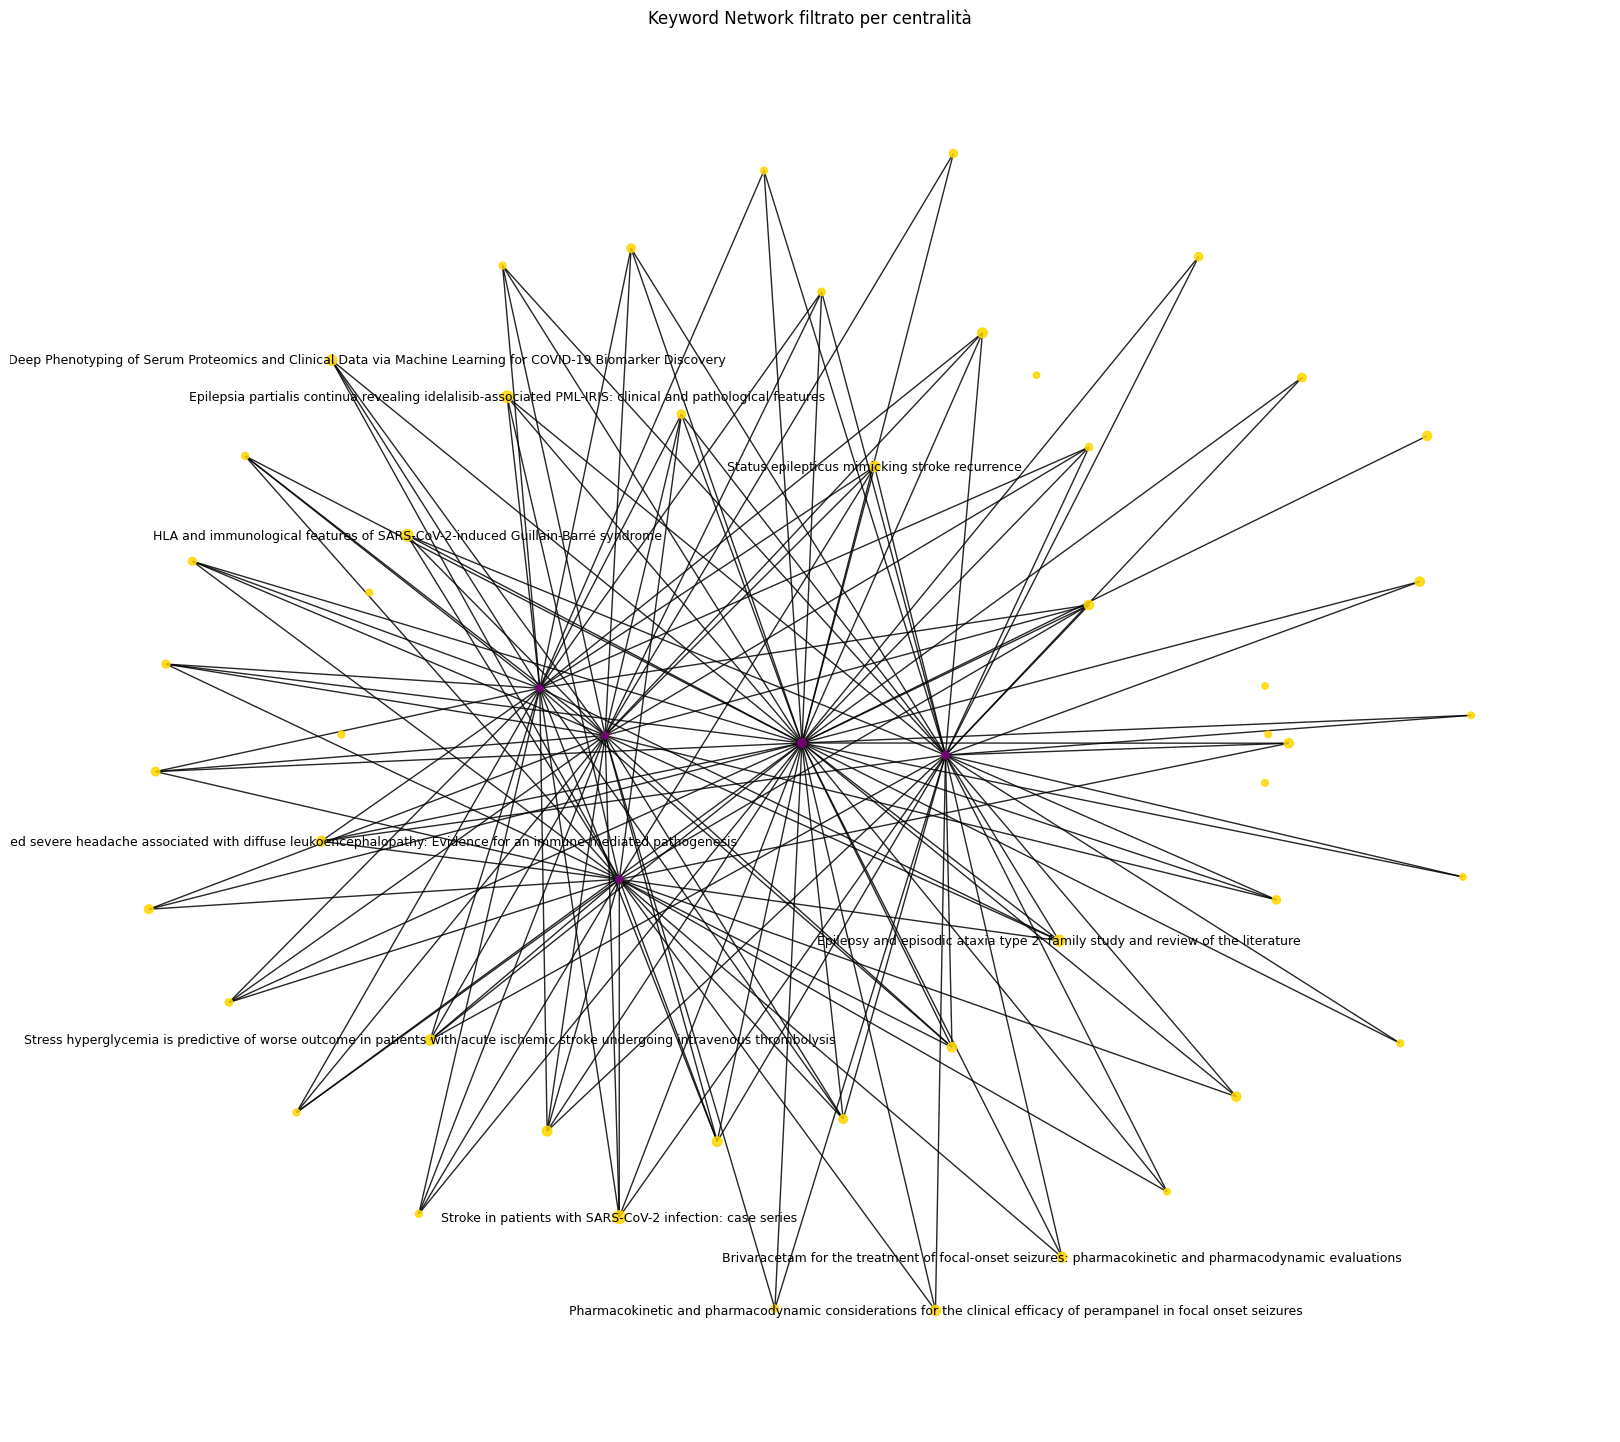

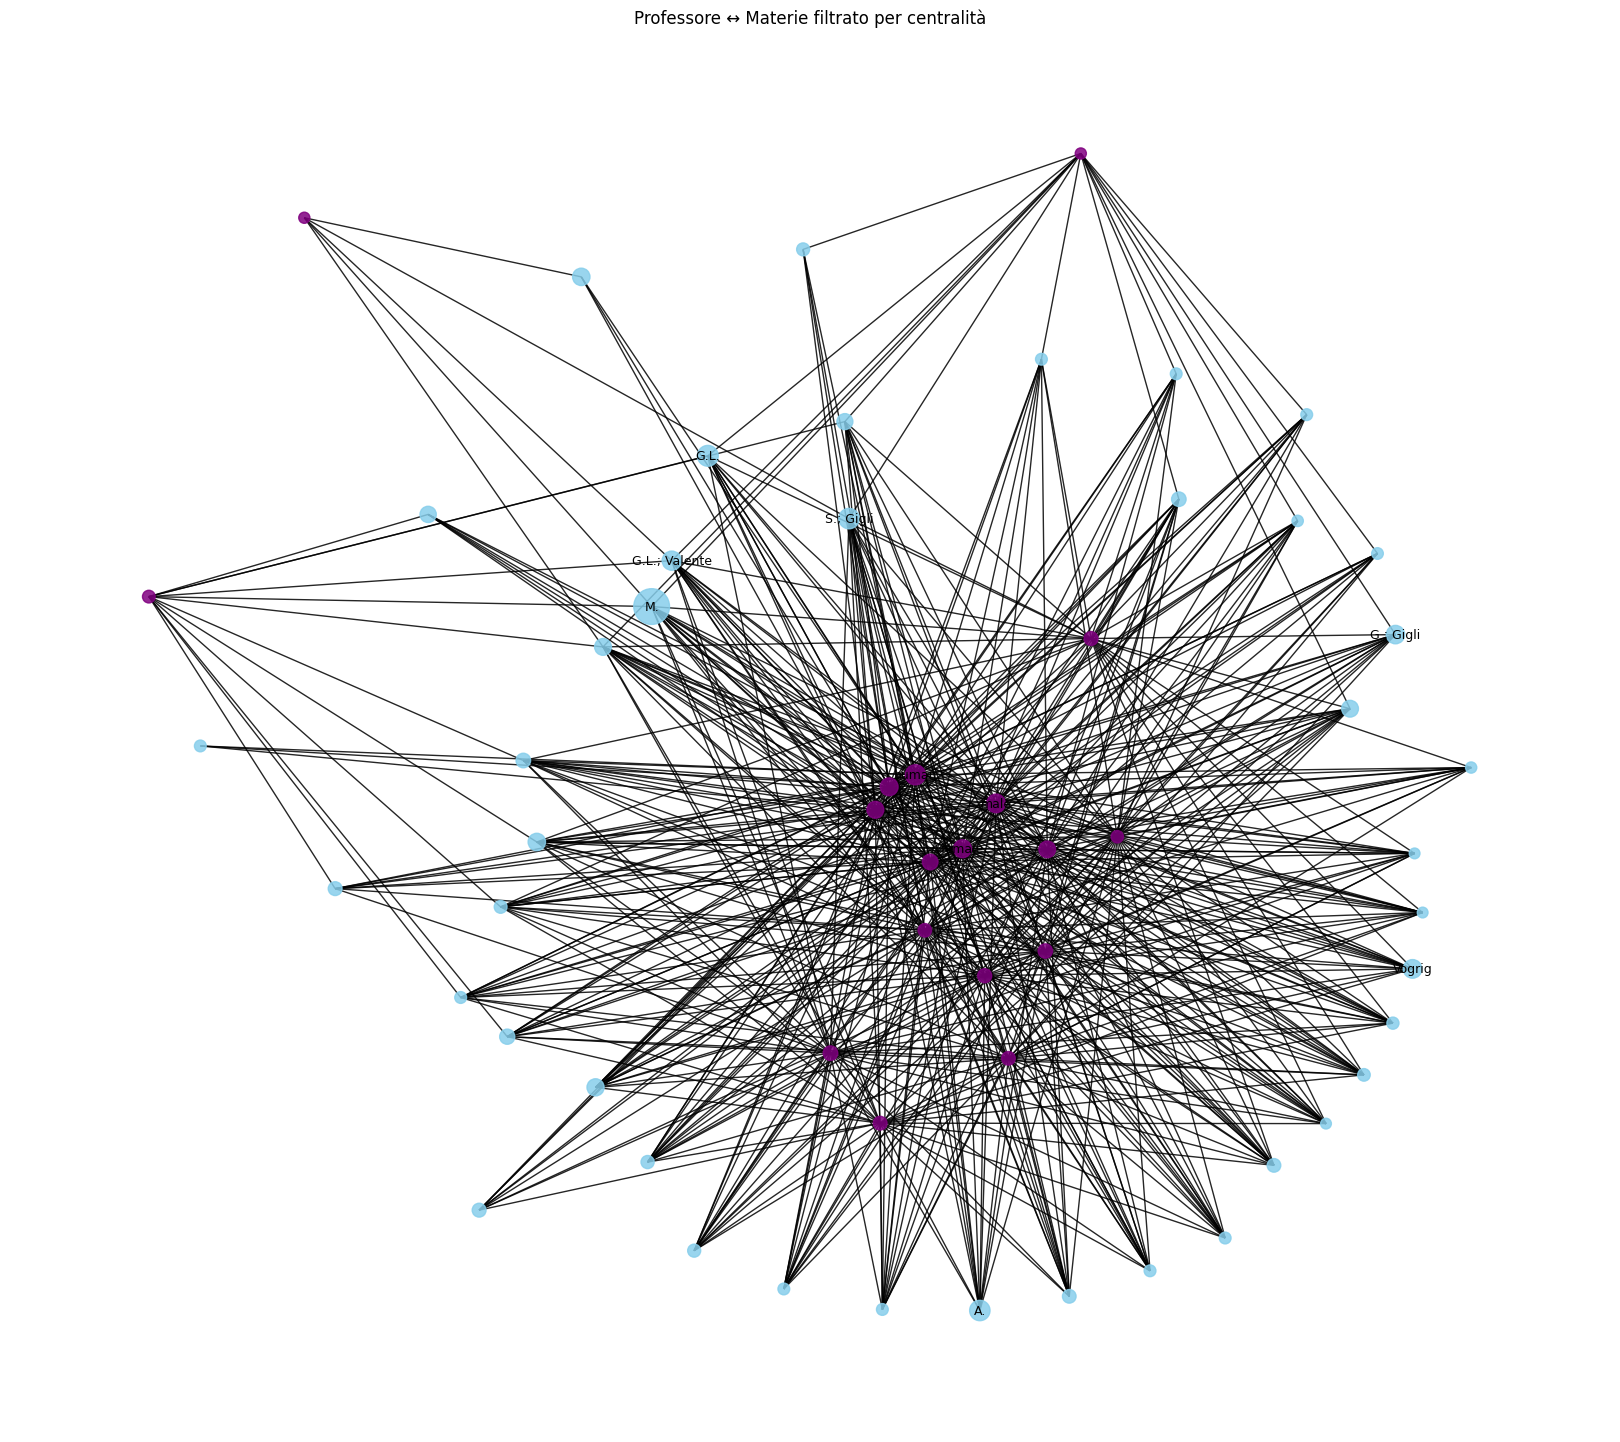

In [ ]:
draw_kamada(G_kw_filt, cent_kw, "Keyword Network filtrato per centralità")
draw_kamada(G_prof_kw_filt, cent_prof, "Professore ↔ Materie filtrato per centralità")

In [ ]:
def compute_layout(G, layout="kamada"):
    if layout == "spring":
        return nx.spring_layout(G, seed=42, k=0.8, iterations=200)

    elif layout == "kamada":
        return nx.kamada_kawai_layout(G)

    elif layout == "circular":
        return nx.circular_layout(G)

    elif layout == "spectral":
        try:
            return nx.spectral_layout(G)
        except:
            return nx.spring_layout(G)

    elif layout == "shell":
        keywords = [n for n in G.nodes() if G.nodes[n]["type"]=="keyword"]
        articles = [n for n in G.nodes() if G.nodes[n]["type"]=="article"]
        if len(keywords) > 0 and len(articles) > 0:
            return nx.shell_layout(G, nlist=[keywords, articles])
        else:
            return nx.spring_layout(G)

    else:
        return nx.spring_layout(G)

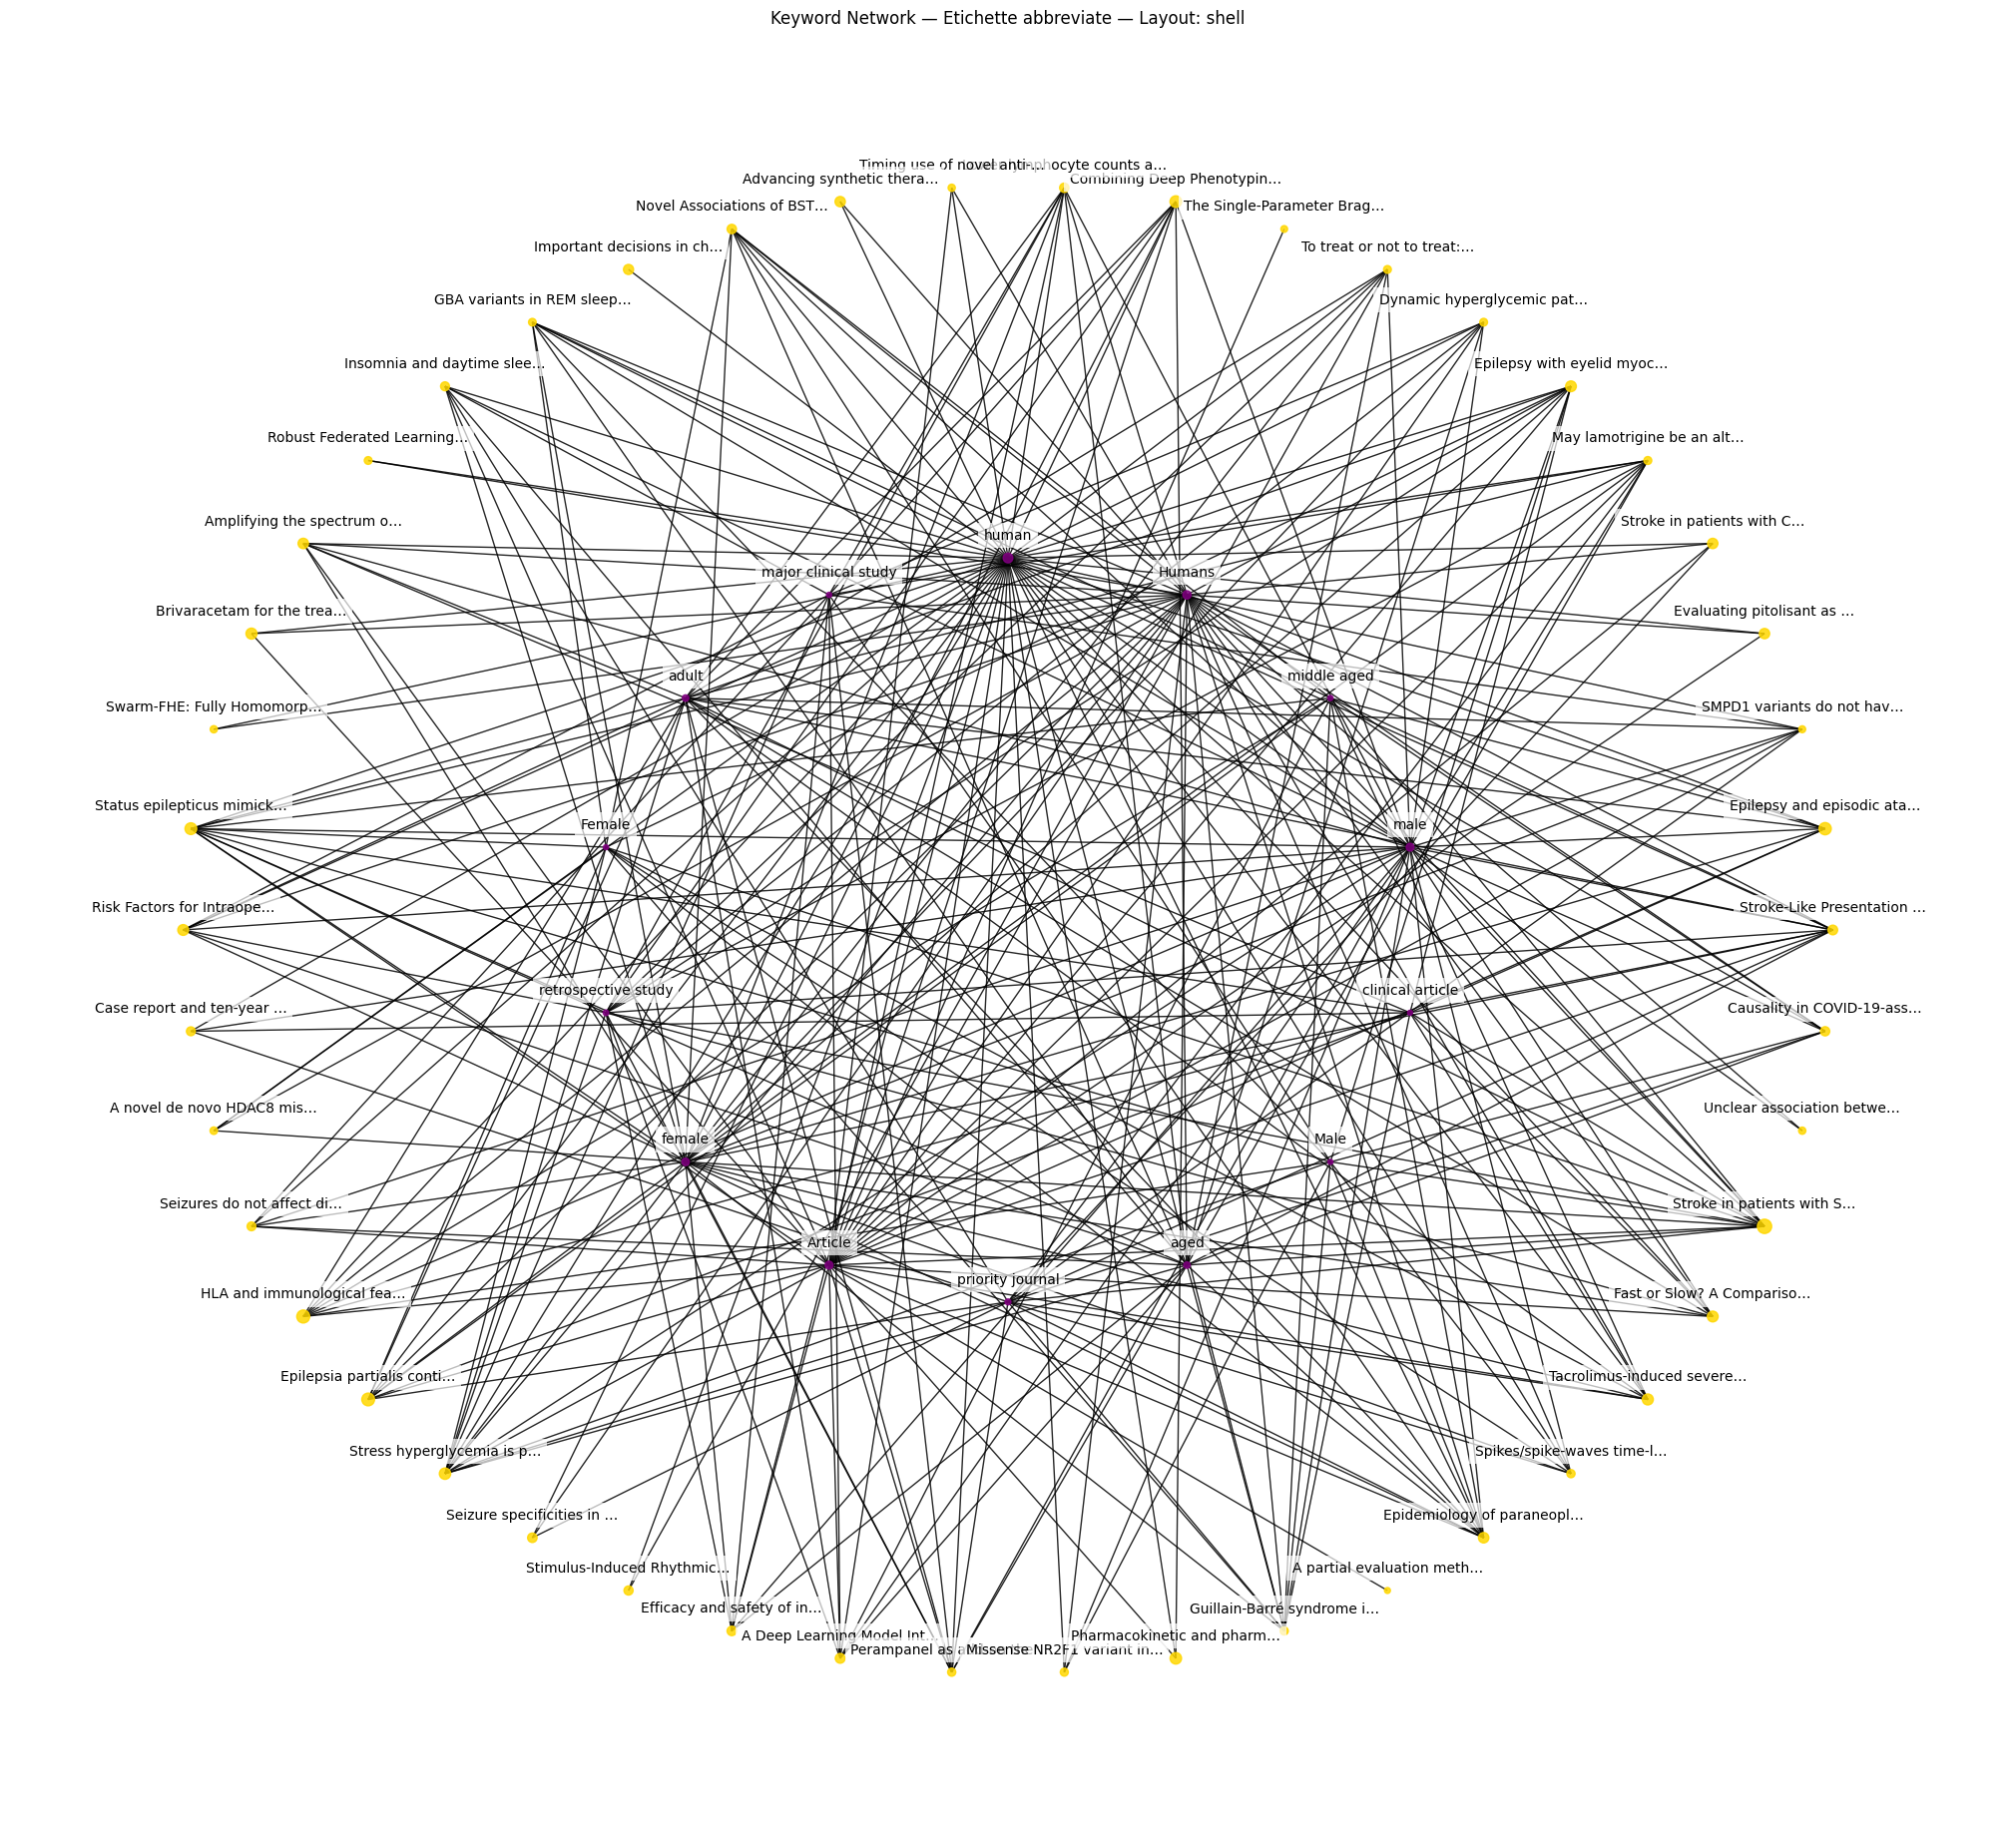

In [ ]:
t=0.005
def filter_by_centrality(G, threshold=t):
    cent = nx.degree_centrality(G)
    nodes_to_keep = [n for n, c in cent.items() if c >= threshold]
    return G.subgraph(nodes_to_keep).copy(), cent

G_kw_filt, cent_kw = filter_by_centrality(G_kw, threshold=t) #REGOLARE
LAYOUT = "shell" ## FORSE CI PIACE
G_kw_filt = G_kw_filt.subgraph([n for n in G_kw_filt if G_kw_filt.degree(n) > 0]).copy()
pos_kw = compute_layout(G_kw_filt, layout=LAYOUT)

plt.figure(figsize=(20,18))

sizes = [cent_kw[n] * 2500 for n in G_kw_filt.nodes()]
colors = [
    "gold" if G_kw_filt.nodes[n]["type"]=="article" else "purple"
    for n in G_kw_filt.nodes()
]

nx.draw(
    G_kw_filt, pos_kw,
    node_size=sizes,
    node_color=colors,
    with_labels=False,
    alpha=0.85
)

# --- etichette meno complete ---
def shorten_label(text, maxlen=25):
    return text if len(text) <= maxlen else text[:maxlen] + "…"

labels_all = {n: shorten_label(n) for n in G_kw_filt.nodes()}

offset_pos = {n: (x, y+0.03) for n, (x, y) in pos_kw.items()}

nx.draw_networkx_labels(
    G_kw_filt, offset_pos, labels_all,
    font_size=10,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
)

plt.title(f"Keyword Network — Etichette abbreviate — Layout: {LAYOUT}")
plt.show()